## Imports and Setups

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from tadgan_tf2 import preprocessing, tadgan, postprocessing, utils

In [4]:
# set constants and hyperparameters

DATASET = 'realKnownCause/output.csv'

# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [5]:
# import time series

x = pd.read_csv(f'NAB data/{DATASET}')

x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S")
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

Number of time stamps: 216546
First 3 time stamps: 2020-07-01 10:11:35, 2020-07-02 15:51:53, 2020-07-02 15:54:35
Last 3 time stamps: 2023-09-07 12:48:25, 2023-09-07 13:09:13, 2023-09-07 13:12:28


,temperature
count,2.165460e+05
mean,-1.045808e+03
std,3.531911e+05
min,-1.162173e+08
25%,2.540000e+01
50%,2.810000e+01
75%,2.960000e+01
max,4.430000e+01


In [33]:
temp = x['temperature']
temp = temp[temp>=18]
temp = temp.resample('H', base=30).mean()
print(temp)

train = temp[(temp.index.year<2022) | ((temp.index.year==2022)&(temp.index.month<9))]
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

time
2020-07-02 15:00:00    24.366667
2020-07-02 16:00:00          NaN
2020-07-02 17:00:00          NaN
2020-07-02 18:00:00          NaN
2020-07-02 19:00:00    28.938889
                         ...    
2023-09-07 09:00:00    31.950000
2023-09-07 10:00:00    35.340000
2023-09-07 11:00:00    35.900000
2023-09-07 12:00:00    37.060000
2023-09-07 13:00:00    36.600000
Freq: H, Name: temperature, Length: 27887, dtype: float64


time
2020-07-02 15:00:00    24.366667
2020-07-02 16:00:00          NaN
2020-07-02 17:00:00          NaN
2020-07-02 18:00:00          NaN
2020-07-02 19:00:00    28.938889
Freq: H, Name: temperature, dtype: float64

## Prepare Training Data

To prepare training data for the reconstruction model, we apply to the raw time series a pipeline of preprocessing steps. The main steps are, in order:
- resample the time series at a specified frequency
- rescale values to between 0 and 1
- collect (overlapping) segments of the time series over rolling windows of a fixed specified length (which will be the input dimension of the reconstruction model)



In [7]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [8]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 18870
Start times of the first 3 windows: ['2020-07-02T15:00:00.000000000' '2020-07-02T16:00:00.000000000'
 '2020-07-02T17:00:00.000000000']


## Train Reconstruction Model (TadGAN)

In [9]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [10]:
# train the model

t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
t1 = time.time()

Epoch 1/100 (276.7 secs)
  Critic X Loss: 0.716085 [-5.11933964  4.38512768  0.14502971]
  Critic Z Loss: -0.535110 [-0.17048929 -1.9143514   0.15497307]
  Encoder Generator Loss: 0.909820 [-4.34860567  2.46730317  0.27911226]
Epoch 2/100 (286.7 secs)
  Critic X Loss: -1.197156 [-7.64085812  6.14307333  0.03006292]
  Critic Z Loss: -0.147015 [ 0.60483661 -1.95995251  0.12081012]
  Encoder Generator Loss: -1.202021 [-6.00391338  2.24687435  0.25550176]
Epoch 3/100 (274.6 secs)
  Critic X Loss: -0.901894 [-5.68400127  4.56610837  0.0215999 ]
  Critic Z Loss: 0.562852 [ 0.82068943 -1.37106639  0.1113229 ]
  Encoder Generator Loss: -0.837857 [-4.4478248   1.63270091  0.19772664]
Epoch 4/100 (291.2 secs)
  Critic X Loss: -1.643942 [-14.48673014  12.57608675   0.02667011]
  Critic Z Loss: 2.150254 [ 1.14415142 -0.23864211  0.12447448]
  Encoder Generator Loss: -11.458603 [-12.54217923   0.32321589   0.07603607]
Epoch 5/100 (293.2 secs)
  Critic X Loss: -0.554251 [-11.30260805  10.38725459   

In [11]:
print(f'Total training time for {EPOCHS} epochs: {t1 - t0:.1f} secs')

Total training time for 100 epochs: 19566.4 secs


## Generate Reconstructed Time Series

With a trained TadGAN model, we feed the original time series segments (over rolling windows) to the following components of the model:
1. **encoder $\rightarrow$ generator**, which produces **reconstructed versions** of the segments,
2. **input space critic**, which produces **critic scores** of the segments.



In [32]:
# generate reconstructed time series segments
print(x_win[0])
x_win_recon, critic_scores = model.predict(x_win)

[ 0.36046626 -1.         -1.         -1.          0.61574754  0.59829562
  0.60684344  0.61568886  0.62474287  0.62474287  0.62474287  0.62474287
  0.62474287  0.62474287  0.62474287  0.62474287  0.62474287  0.62430209
  0.62474287  0.62474287 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.          0.81904202  0.87180429  0.7643256   0.74757567
  0.75315898  0.75595063  0.75315898  0.74757567  0.72245078  0.73640905
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.          0.59682633  0.68615927  

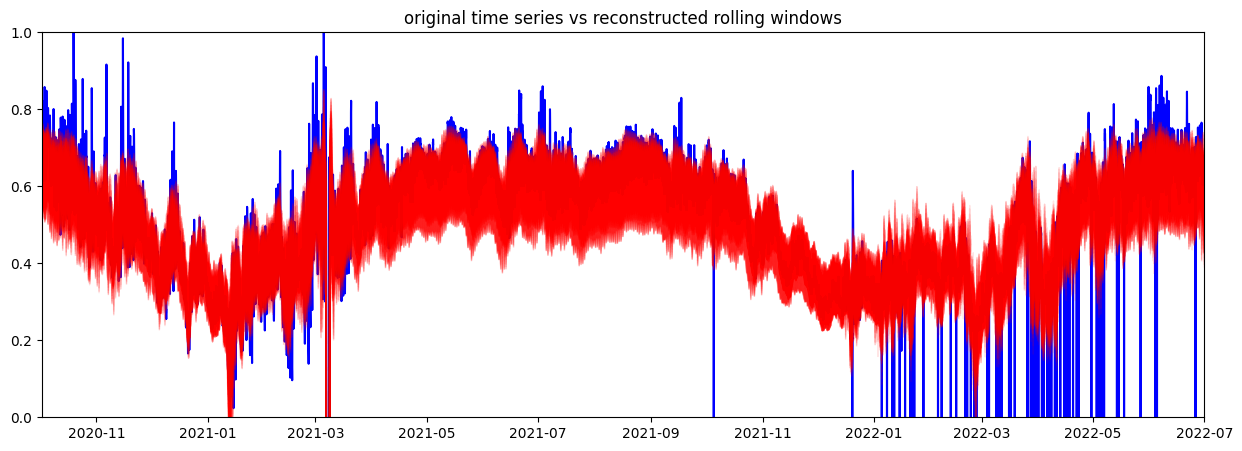

In [28]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2020-10-02', '2022-07-01'], value_range=[0, 1],
                       title='original time series vs reconstructed rolling windows')

## Identify Anomalous Intervals

In [22]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

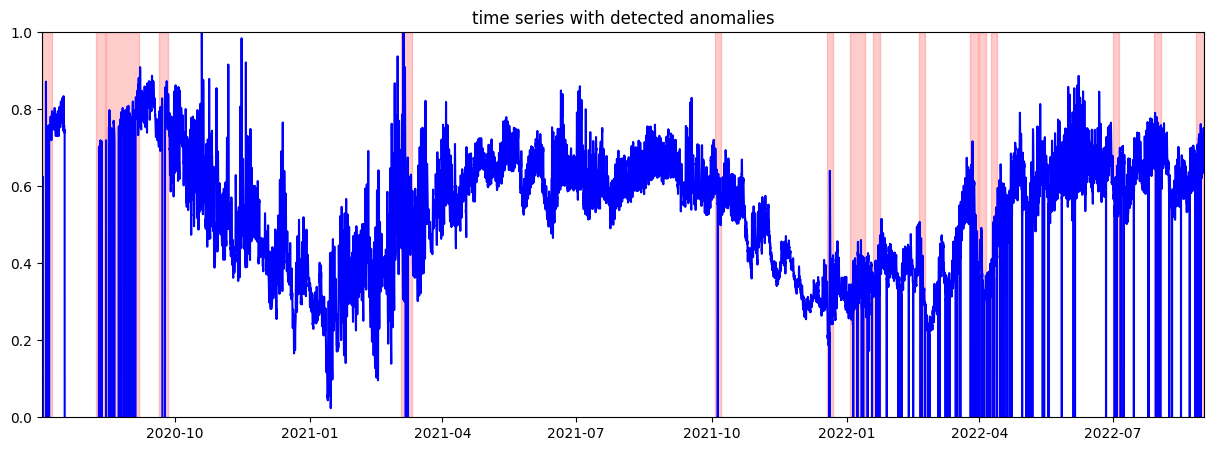

In [23]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[0, 1], title='time series with detected anomalies')